In [1]:
import math
import importlib
import src
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Union
from matplotlib import pyplot as plt
from src.utils import fetch_data, plot_categorical_features
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind, kruskal
importlib.reload(src.utils)

<module 'src.utils' from 'f:\\data science\\ml projects\\ml project by engineering wala bhaiya\\ml_pipeline_project\\src\\utils.py'>

## Functions

### 1. Plotting Heatmap Function
This function is used ot plot a `heatmap` of the `correlation matrix` of a given dataset.

In [2]:
def heatmap_for_scores(score: pd.DataFrame, score_name: str, **kwargs):
    plt.figure(figsize=(8, 3))
    sns.heatmap(score.drop(columns=['P-Value']).set_index('Feature').T, annot=True, fmt=".2f", **kwargs)
    plt.title(f"{score_name} Scores for Categorical Features", fontsize=16)
    plt.show()

### 2. Label Encoding Function
These functions is desinged for the special case where we encode the categories for making a tests on different `correlation matrix`.

In [3]:
def label_encoding_for_correlation(data: pd.DataFrame, split: bool = True) -> pd.DataFrame:
    # Encoding Categorical Features
    encoded_data = data.copy()
    for col in encoded_data:
        le = LabelEncoder()
        encoded_data[col] = le.fit_transform(encoded_data[col])
    
    if split:
    # Splitting Data into Features and Target Variables
        X = encoded_data.drop(columns=['income'])
        y = encoded_data['income']
        return X, y
    else:
        return encoded_data

def df_for_correlation(test_data: Union[list, dict]) -> pd.DataFrame:   
    # Converting them Back Into DataFrame
    test = pd.DataFrame(data=test_data)    # Where test_data is a list of dictionaries
    test.sort_values(by=test.columns[1], ascending=False, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return test

### 3. Scatter Non-Linear Features Function


In [ ]:
def plot_amoung_dependent_features(data: pd.DataFrame):
    
    # Plotting the amount of dependent features
    features = data.drop(columns=['income']).columns
    for i, col in enumerate(features):
        plot_categorical_features(
        data=data,
        columns=features,
        y=col,
        fixed_hue='income',
        plot_type='scatterplot',
        x_axis_label=data.drop(columns=[col, 'income']).columns,
        y_axis_label=col,
        subplot_title=[f'{col} vs {feature}' for feature in data.drop(columns=[col, 'income']).columns.to_list()],
        main_title=f"{col} distribution across features grouped by income level",
        palette='Dark2'
    )

## Data Collection & Import
We just collect the data from just only one source `.CSV`, and import it into our environment using pandas library.

### 1. Import Data

In [5]:
income_data = fetch_data(FILE_NAME='income_evaluation.csv', DIRECTORY_NAME='raw')
income_data.columns = [col.replace('-', '_').strip() for col in income_data.columns]
income_data.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,39,77516,13,2174,0,40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,50,83311,13,0,0,13,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,38,215646,9,0,0,40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,53,234721,7,0,0,40,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,28,338409,13,0,0,40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [4]:
income_data.attrs['source'] = 'Kaggle'
income_data.attrs['url'] = 'https://www.kaggle.com/datasets/lodetomasi1995/income-classification'
income_data.attrs['problem'] = 'Income Classification'
income_data.attrs['published by'] = 'Lorenzo De Tomasi'

### 2. Understand Data Structure
We replace the missing values `?` with `NaN`, and printing all the information related to DataFrame

In [61]:
income_data_missing = income_data.replace(to_replace='?', value=np.nan)
income_data_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   fnlwgt          32561 non-null  int64 
 2   education_num   32561 non-null  int64 
 3   capital_gain    32561 non-null  int64 
 4   capital_loss    32561 non-null  int64 
 5   hours_per_week  32561 non-null  int64 
 6   workclass       30725 non-null  object
 7   education       32561 non-null  object
 8   marital_status  32561 non-null  object
 9   occupation      30718 non-null  object
 10  relationship    32561 non-null  object
 11  race            32561 non-null  object
 12  sex             32561 non-null  object
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Data Cleaning
After importing data we will clean the data by removing any missing values, removing duplication and other operations.

### 1. Handling Missing Values
In this step we will import income data that has already been imputed by using of `Random Forent Classifier`.

In [5]:
imputed_income_data = fetch_data(FILE_NAME='Imputed_Income_Dataset_RF.csv', DIRECTORY_NAME='processed')
imputed_income_data.columns = [col.replace('-', '_').strip() for col in imputed_income_data.columns]
imputed_income_data.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,39,77516,13,2174,0,40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,50,83311,13,0,0,13,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,38,215646,9,0,0,40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,53,234721,7,0,0,40,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,28,338409,13,0,0,40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


### 2. Removing Duplicated Rows
We have removed all duplicated rows fomr the table, that it lead to an leakage of the data towards the model

In [7]:
imputed_income_data.duplicated().value_counts()

False    32537
True        24
Name: count, dtype: int64

In [6]:
imputed_income_data.drop_duplicates(inplace=True)
imputed_income_data.shape

(32537, 15)

### 3. Correcting Data Entery Errors and Inconsistencies

#### 1. Splitting Data
Here we splite the dataset based on there data type, which gonna be use for further operations.

In [7]:
imputed_income_data_obj = imputed_income_data.select_dtypes(include=['object'])
imputed_income_data_int = imputed_income_data.select_dtypes(exclude=['object'])
imputed_income_data_int = pd.concat([imputed_income_data_int, imputed_income_data_obj['income']], axis=1)

#### 2. Inconsistent Data
Inconsistent data can lead to incorrect conclusions and decisions, but here there is no inconsistent data e.g USA & U.S.A

In [101]:
for col in imputed_income_data_obj.columns:
    print(f'< {col.replace("_", " ").title()}: {imputed_income_data_obj[col].unique()} >', end='\n\n')

< Workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked'] >

< Education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th'] >

< Marital Status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed'] >

< Occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv'] >

< Relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative'] >

< Race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'] >

< Sex: ['Male' 'Female'] >

< Native Country: ['United-States' 'Cuba' 'Jamaica' 'India' 'Philippines' 'Mexico' 'South

#### 3. Check the summery of the columns
Some features may contain outliers, which are visible in the summary. These outliers will be handled in the outlier section.

In [102]:
imputed_income_data_int.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### 4. Handling Outliers
Here we dealing with outliers by using normal `Scipy Winsorizer` method without using `Column Transformers`, but later we will use these transformers in further notebooks and on the production sit.<br>
We handle following features as an outlier:
+ Capital Gain
+ Capital Loss
+ Hours Per Week

In [9]:
imputed_income_data_int['hours_per_week'] = winsorize(
    imputed_income_data_int['hours_per_week'].values, limits=(0.001, 0.012)
    ).data

imputed_income_data_int['capital_gain'] = winsorize(
    imputed_income_data_int['capital_gain'].values, limits=(0.05, 0.007)
    ).data

imputed_income_data_int['capital_loss'] = winsorize(
    imputed_income_data_int['capital_loss'].values, limits=(0.05, 0.007)
    ).data

## Data Analysis
This section will go through multiple data analysis techniques to understand it better.

### 1. Univerate Analysis

#### 1. Categorical Univeriate Analysis
In categorical univeriate analysis we will analyse `counts` and the `frequency distribution`

##### 1. Counting Categories

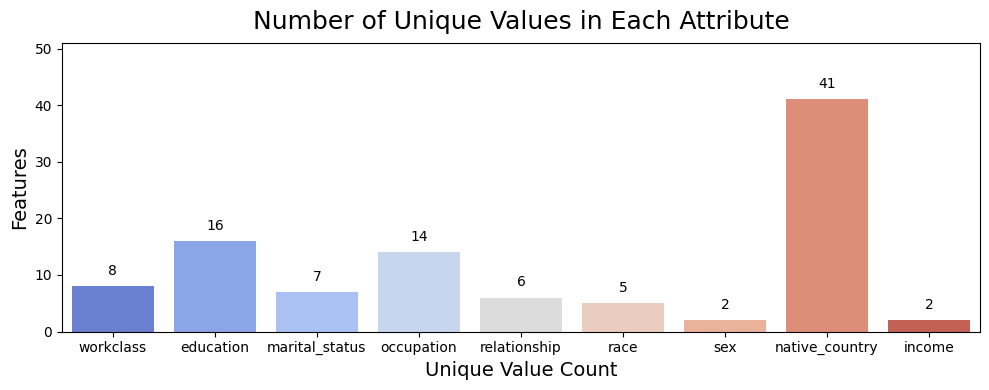

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(
    x=imputed_income_data_obj.nunique().index,
    y=imputed_income_data_obj.nunique().values,
    palette='coolwarm',
    hue=imputed_income_data_obj.nunique().index,
    dodge=False    
)

plt.title("Number of Unique Values in Each Attribute", fontsize=18, pad=10)
plt.xlabel("Unique Value Count", fontsize=14)
plt.ylabel("Features", fontsize=14)
for index, value in enumerate(imputed_income_data_obj.nunique().values):
    plt.text(index, value + 2, str(value), color='black', ha='center')
plt.ylim(0, imputed_income_data_obj.nunique().max() + 10)
plt.tight_layout()
plt.show()

##### 2. Frequency Distribution

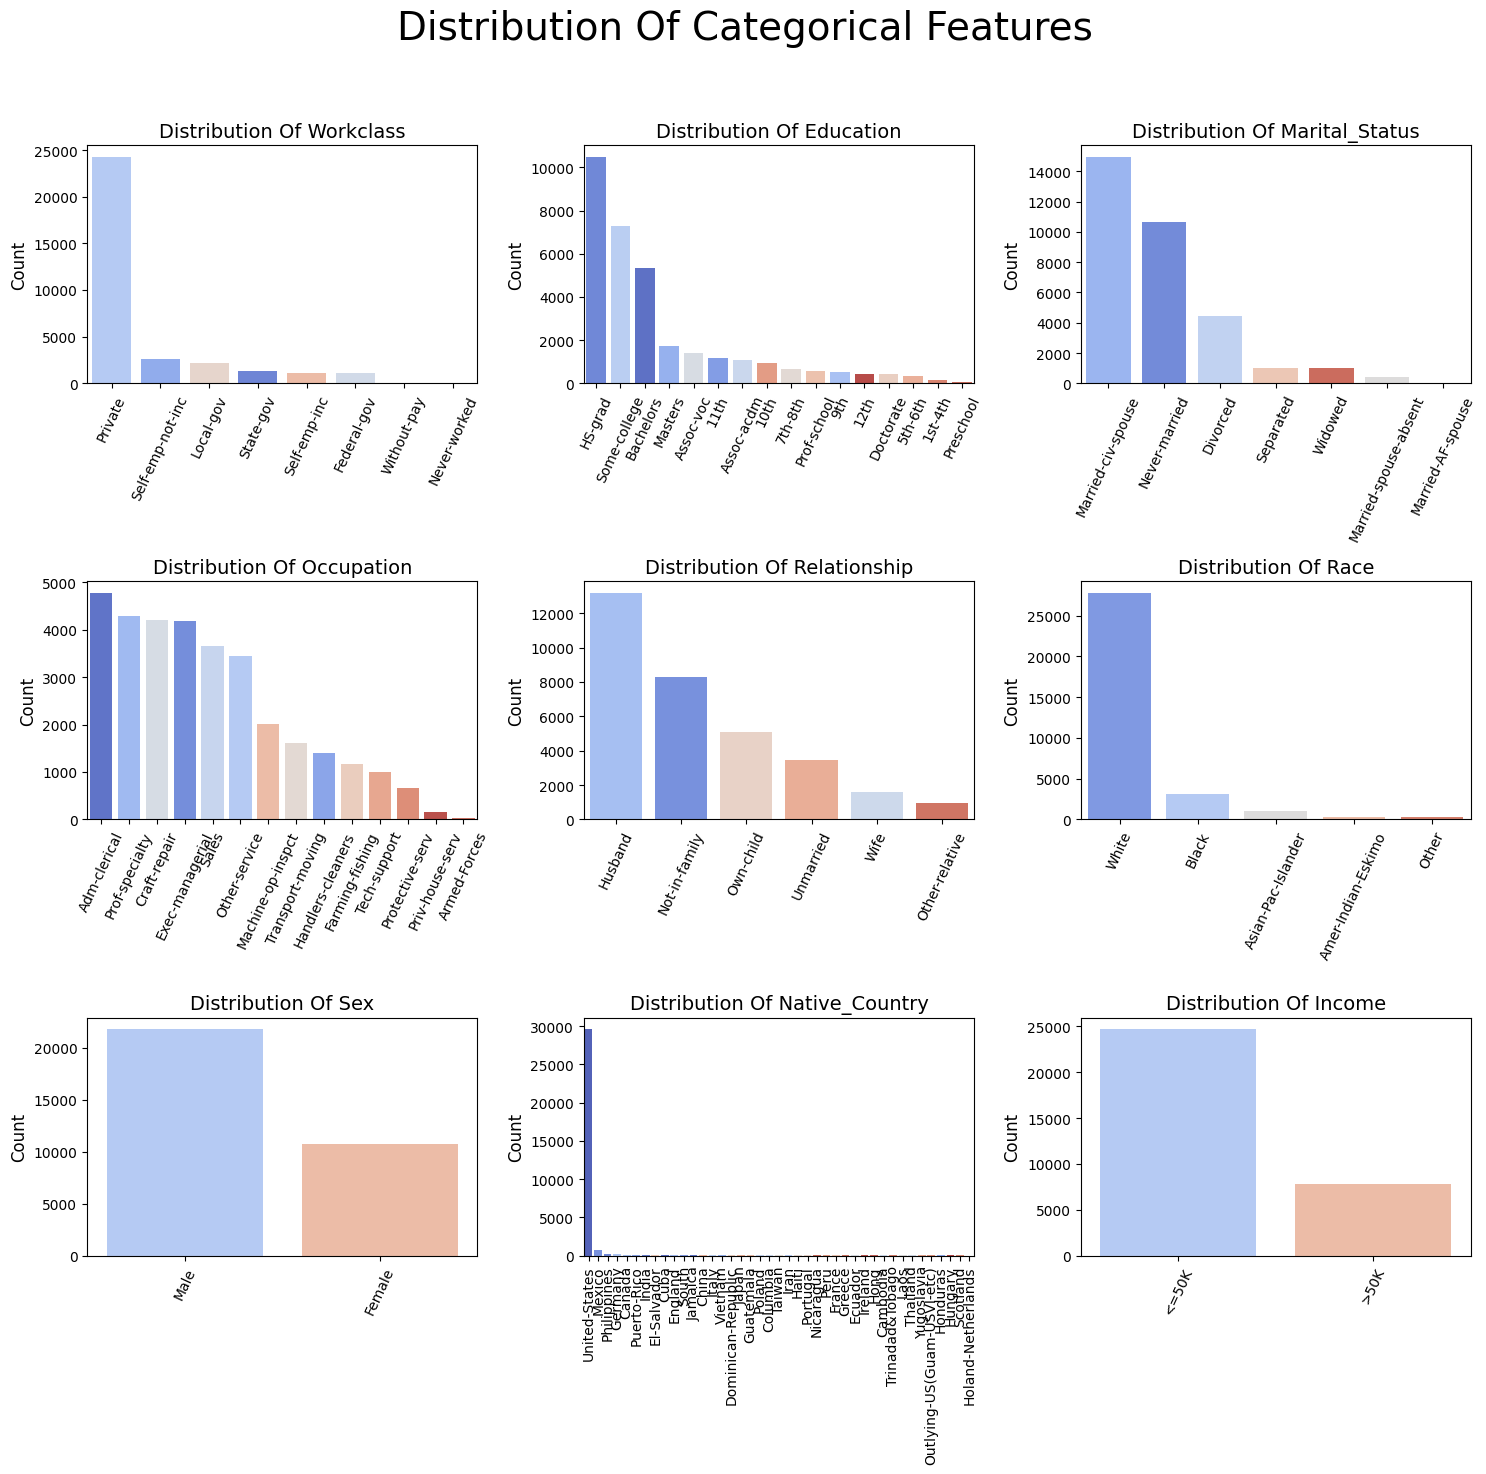

In [ ]:
plot_categorical_features(
    data=imputed_income_data_obj,
    columns=imputed_income_data_obj.columns.to_list(),
    target_col='income',
    plot_type='countplot',
    y_axis_label='Count',
    subplot_title=[f'Distribution of {feature}' for feature in imputed_income_data_obj.columns.to_list()],
    main_title='Distribution of Categorical Features',
    palette='coolwarm'
)

### 2. Bivariate Analysis
Here we dive into the world of bivariate analysis, where we examine the relationship between two variables. We'll explore different concepts like Visualizing, Correlation, and Disrebution. This is a crucial step in understanding the behavior of our data. The analysis will be based on categorical and numerical data.

#### 1. Categorical Bivariate Analysis

##### 1. Frequency Distribution by Income

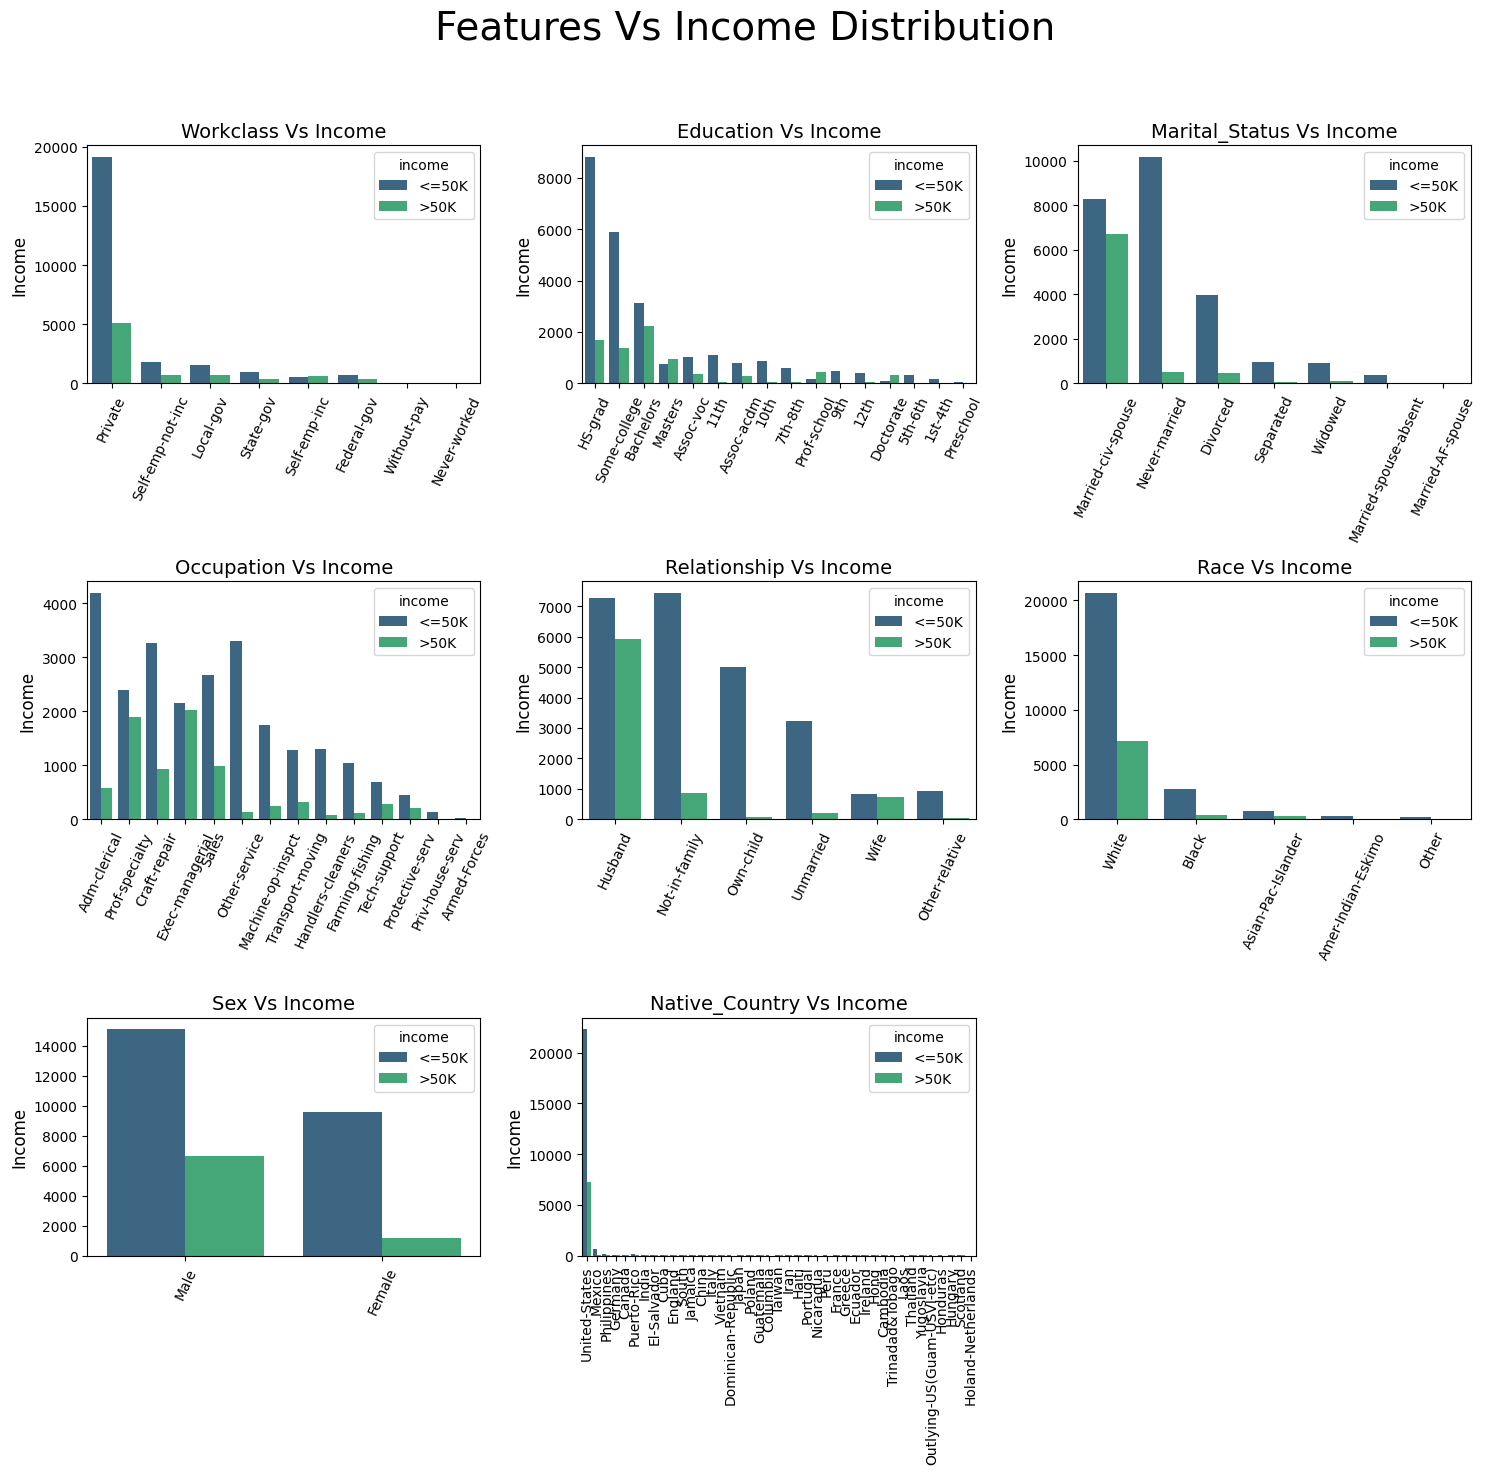

In [ ]:
plot_categorical_features(
    data=imputed_income_data_obj,
    columns=imputed_income_data_obj.drop(columns='income').columns,
    fixed_hue='income',
    plot_type='countplot',
    y_axis_label='Income',
    subplot_title=[f'{feature} vs income' for feature in imputed_income_data_obj.columns.to_list()],
    main_title="features vs income distribution",
    palette='viridis'
)

##### 2. Chi-Square Test

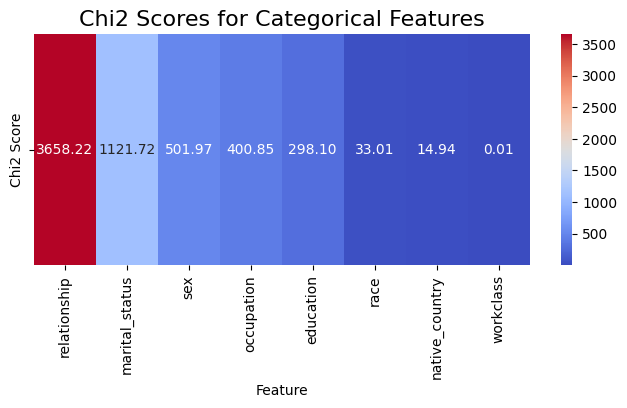

In [59]:
X, y = label_encoding_for_correlation(imputed_income_data_obj)

# Now apply Chi-Square Test
chi2_score, p_value = chi2(X, y)
chi2_result = {'Feature': X.columns, 'Chi2 Score': chi2_score, 'P-Value': p_value}

chi2_score = df_for_correlation(chi2_result)
heatmap_for_scores(chi2_score, 'Chi2', cmap='coolwarm')

##### 3. T-Tests

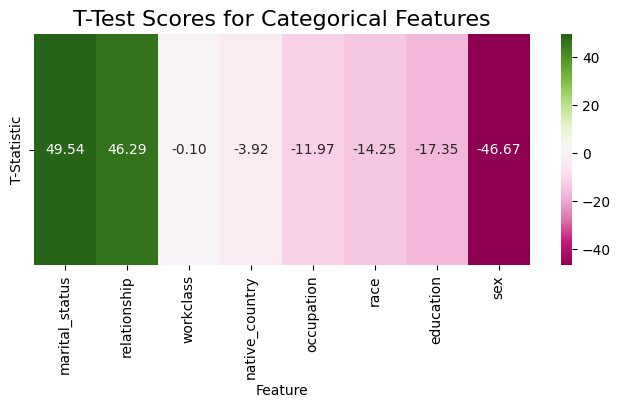

In [63]:
# Transforming Categorical Features in to Numerical Ones (Label Encoding)
label_encoding_for_correlation(imputed_income_data_obj)

# Performing T-Test for Each Feature
t_test_result = []
for col in X.columns:
    group1 = X[col][y == 0]
    group2 = X[col][y == 1]
    
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    t_test_result.append({'Feature': col, 'T-Statistic': t_stat, 'P-Value': p_value})

t_test = df_for_correlation(t_test_result)
heatmap_for_scores(t_test, 'T-Test', cmap='PiYG')

##### 4. Kruskal-Willis Test

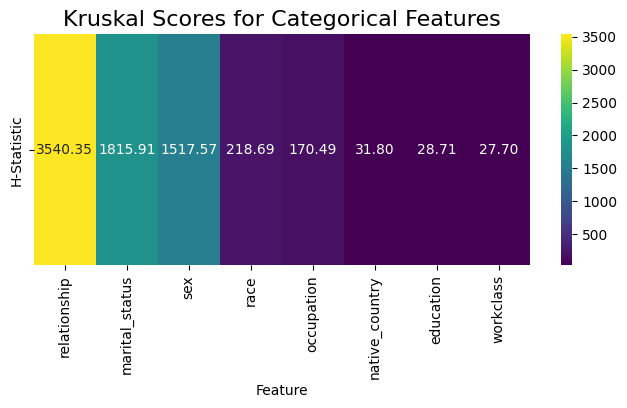

In [64]:
X, y = label_encoding_for_correlation(data=imputed_income_data_obj)

kruskal_result = []
for col in X.columns:
    groups = [X[col][y == group] for group in y.unique()]
    h_stat, p_value = kruskal(*groups)
    kruskal_result.append({'Feature': col, 'H-Statistic': h_stat, 'P-Value': p_value})

kruskal_score = df_for_correlation(kruskal_result)
heatmap_for_scores(kruskal_score, 'Kruskal', cmap='viridis')

#### 2. Numerical Analysis

##### 1. Box Plots

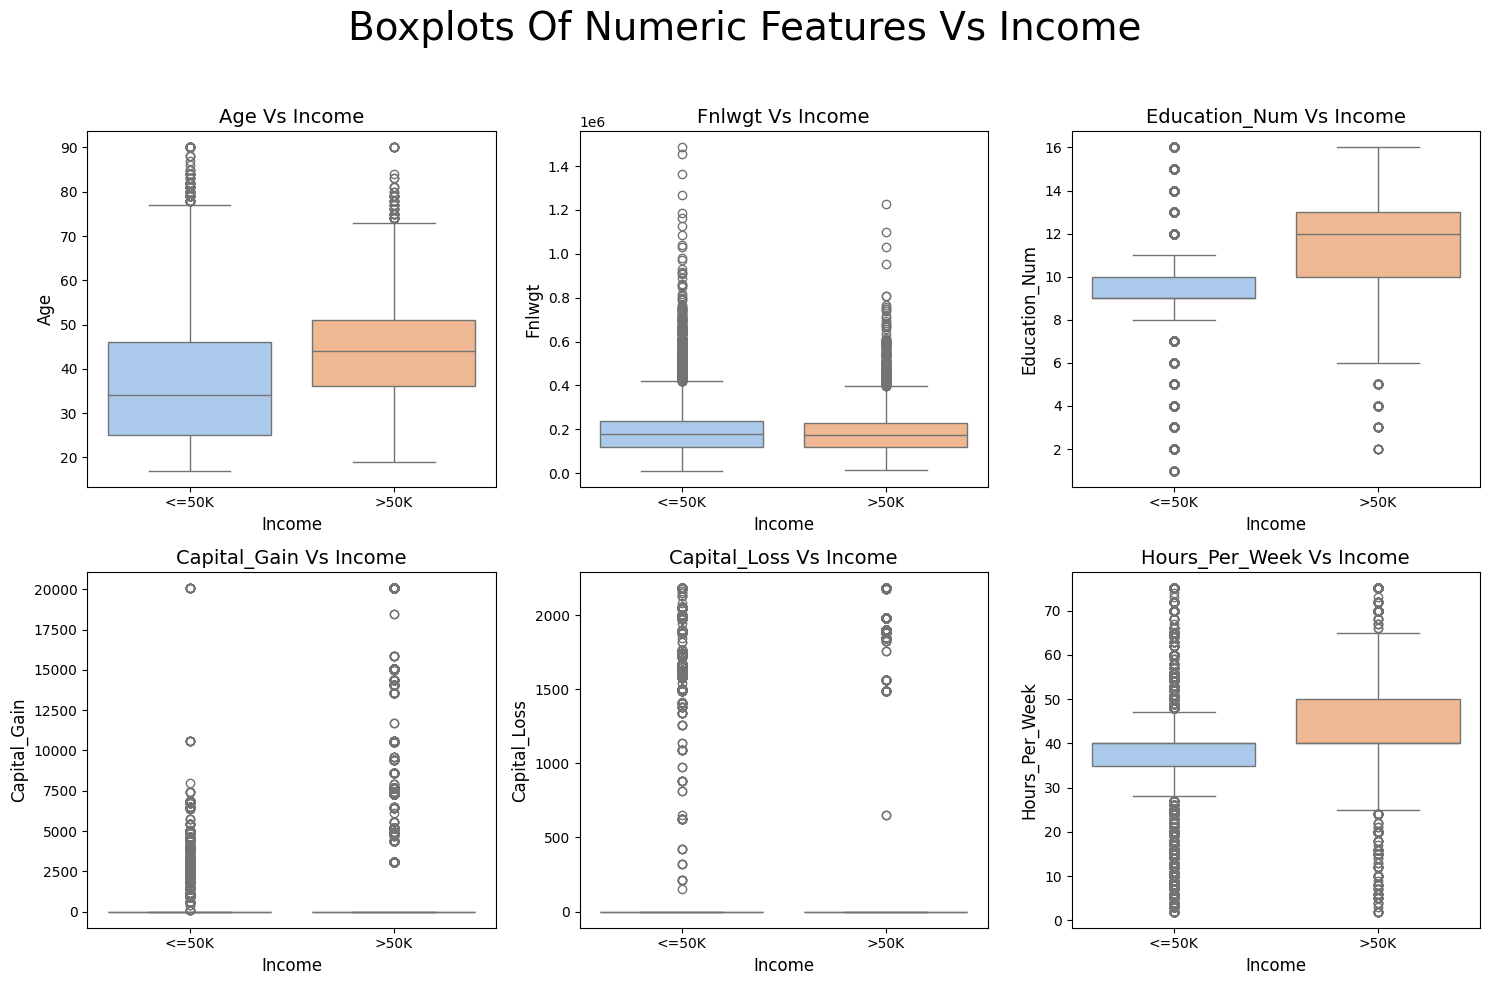

In [ ]:
plot_categorical_features(
    data=imputed_income_data_int,
    columns=imputed_income_data_int.columns[:-1],
    x='income',
    fixed_hue='income',
    plot_type='boxplot',
    y_axis_label=imputed_income_data_int.columns[:-1],
    x_axis_label=imputed_income_data_int.columns[-1],
    subplot_title=[f'{feature} vs income' for feature in imputed_income_data_int.columns[:-1]],
    main_title='Boxplots of Numeric Features vs Income',
    orientation='h',
    palette='pastel'
)


##### 2. Violin Plot

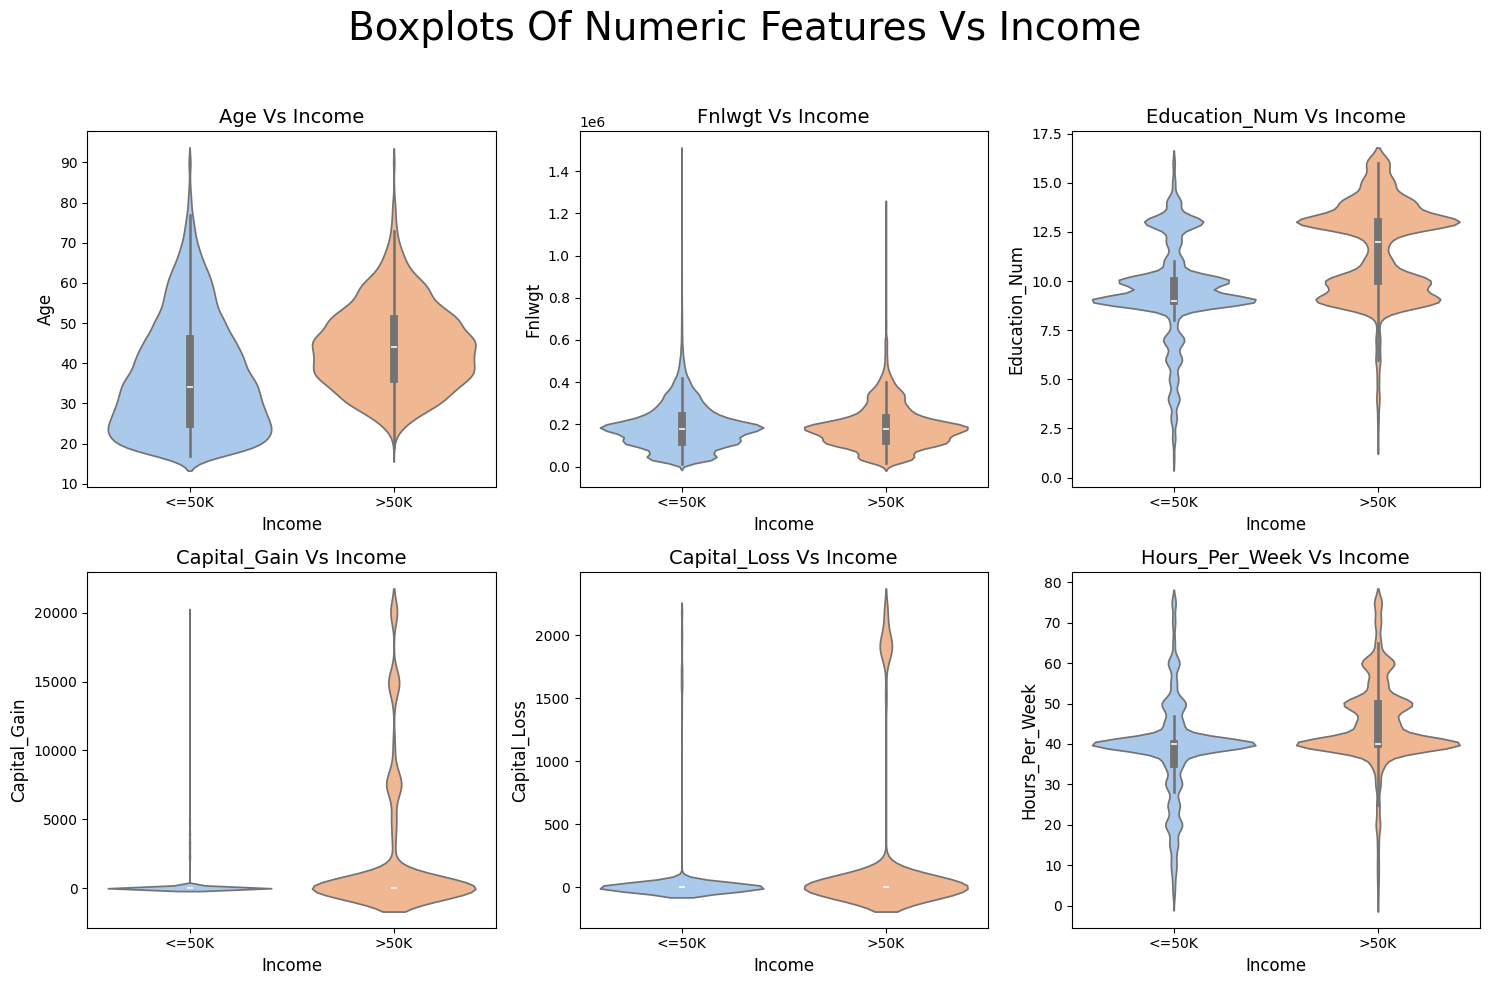

In [13]:
plot_categorical_features(
    data=imputed_income_data_int,
    columns=imputed_income_data_int.columns[:-1],
    x='income',
    fixed_hue='income',
    plot_type='violinplot',
    y_axis_label=imputed_income_data_int.columns[:-1],
    x_axis_label=imputed_income_data_int.columns[-1],
    subplot_title=[f'{feature} vs income' for feature in imputed_income_data_int.columns[:-1]],
    main_title='Boxplots of Numeric Features vs Income',
    orientation='h',
    palette='pastel'
)

##### 3. Scatter Plot

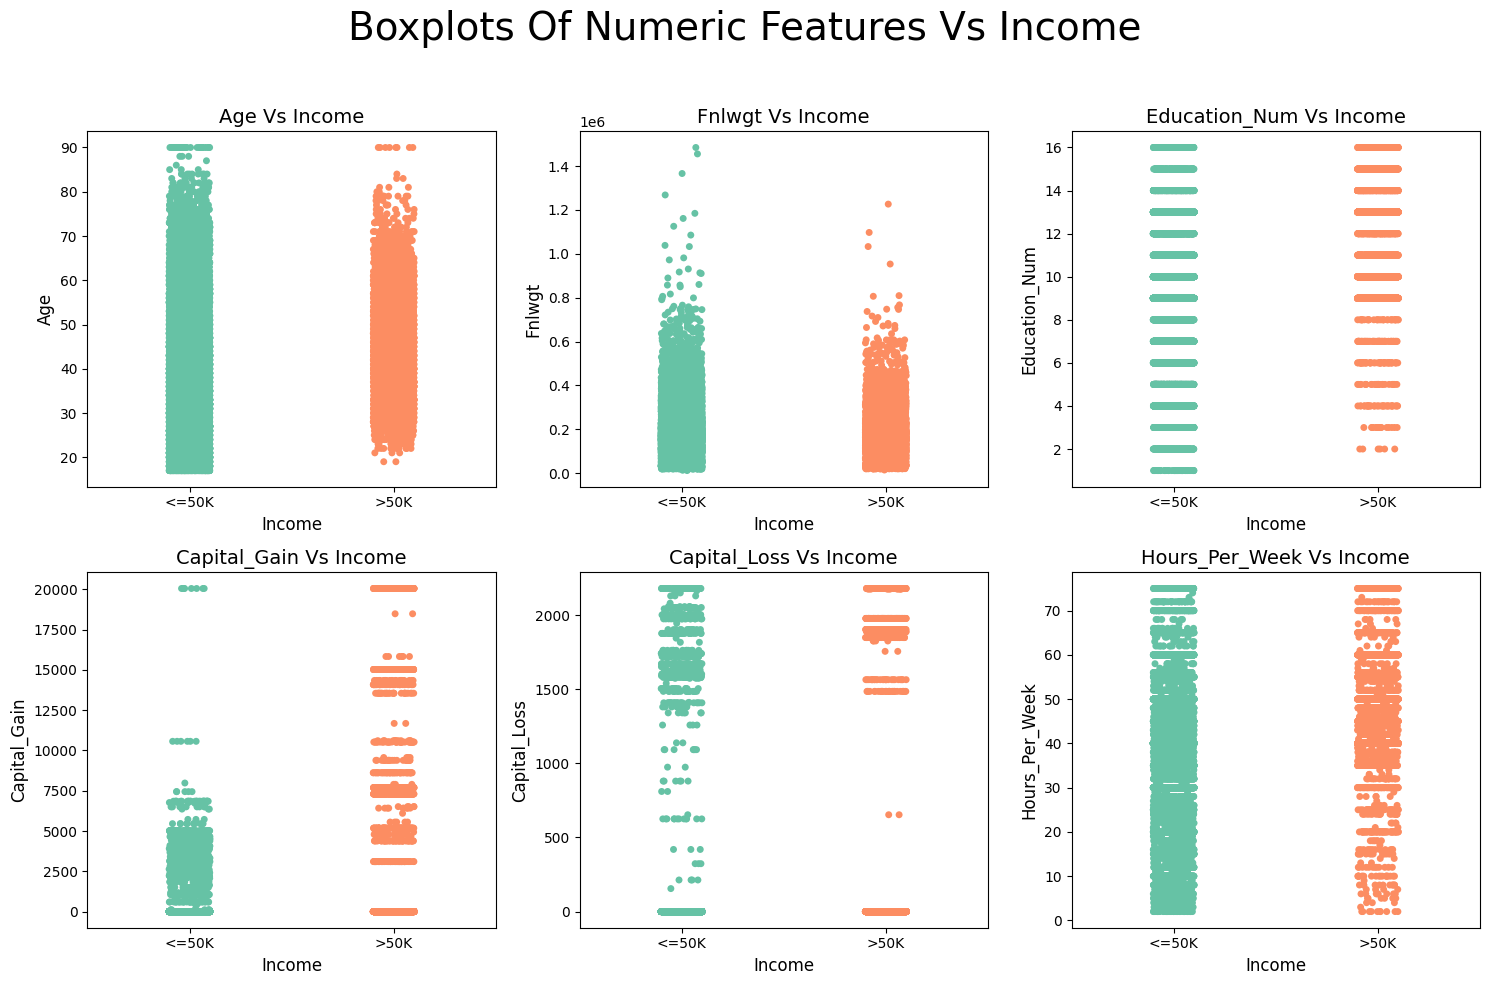

In [17]:
plot_categorical_features(
    data=imputed_income_data_int,
    columns=imputed_income_data_int.columns[:-1],
    x='income',
    fixed_hue='income',
    plot_type='stripplot',
    y_axis_label=imputed_income_data_int.columns[:-1],
    x_axis_label=imputed_income_data_int.columns[-1],
    subplot_title=[f'{feature} vs income' for feature in imputed_income_data_int.columns[:-1]],
    main_title='Boxplots of Numeric Features vs Income',
    orientation='h',
    palette='Set2'
)

##### 4. Heatmap For Correlations
To analyze the relationships between different features, we used the `Pearson Correlation Coefficient` and visualized it with a heatmap. This allowed us to observe how each pair of features correlates, segmented by income levels. By leveraging the heatmap, we gained insights into the strength and direction of relationships between features under each income category. <br><br>

<u><i><b>Conclusion</b></i></u>: **Using the heatmap, we identified notable patterns and relationships between features. Below are the key observations:**
1. **Age & Capital Gain**:
    + Exhibits a `strong positive relationship` in both income levels.

2. **Education Number & Hours per Week**:
    + Also shows a `strong positive relationship` in both income levels, though there is some `variance` across categories.

3. **FNLWGT (Final Weight) with Capital Gain & Capital Loss**:
    + Demonstrates `no significant relationship` in either income category.

4. **Hours per Week & Age**:
    + Displays a `strong negative relationship` in the `Income > $50K` category.
    + Shows a `weak positive relationship` in the `Income <= $50K` category.

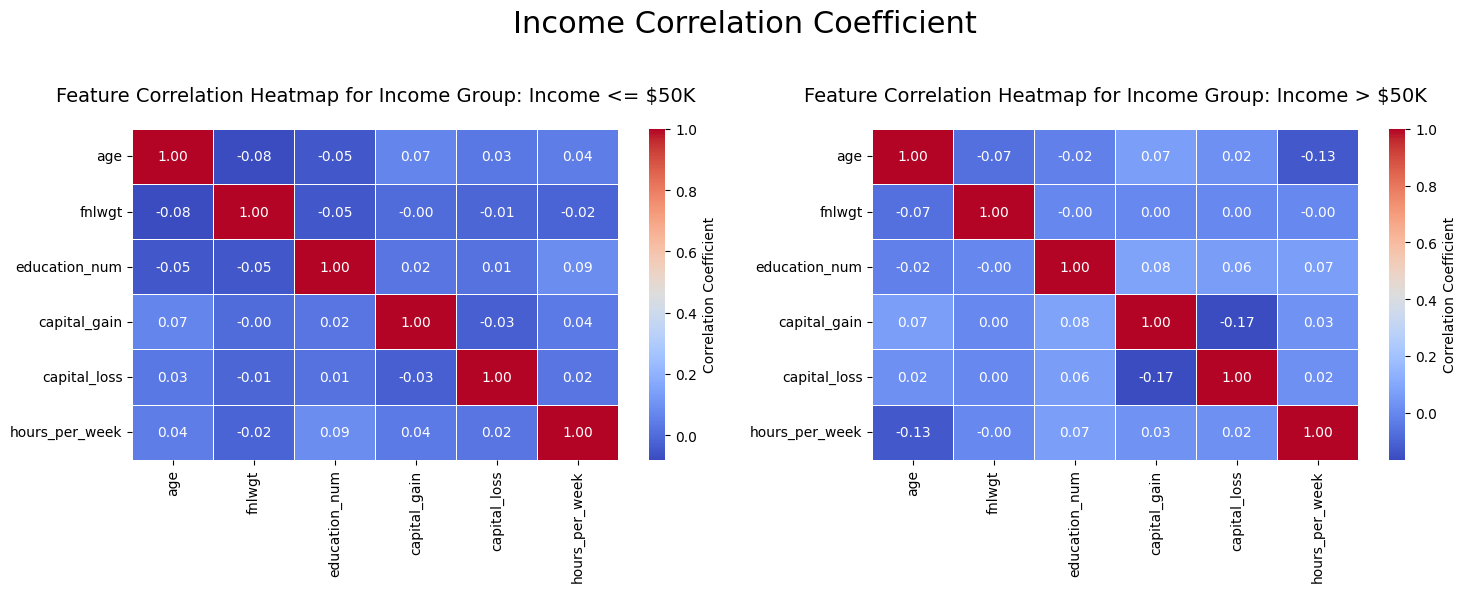

In [ ]:
# Calculating the Correlation Coefficient on Income at Each Category
imputed_income_corr = label_encoding_for_correlation(data=imputed_income_data_int, split=False)
imputed_income_corr = imputed_income_corr.iloc[:, :-1].groupby(imputed_income_corr['income']).apply(lambda x: x.corr())

# Plotting Correlations Heatmapa Using Subplots According to Each Categoy
income_category_dict = {0: 'Income <= $50K', 1: 'Income > $50K'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = ax.flatten()

# Itrating Over Each Category and Plotting Heatmap
for index, (income_category, corr_matrix) in enumerate(imputed_income_corr.groupby(level=0)):
    
    # Droping Multi Index From Correlation Matrix
    corr_matrix = corr_matrix.droplevel(level=0)
    # Plotting Heatmap
    sns.heatmap(
        data=corr_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'},
        ax=ax[index]
    )
    # Adding Title to Each Heatmap
    ax[index].set_title(
        f'Feature Correlation Heatmap for Income Group: {income_category_dict[income_category]}',
        fontsize=14,
        pad=20
        )

# Layout So That Plots Do Not Overlap
fig.suptitle('Income Correlation Coefficient', fontsize=22)
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])
plt.show()

##### 5. Pair Plot
To explore any potential `non-linear relationships` between the features that may not have been captured by the `Pearson Correlation Coefficient`, we created a pair plot. This visualization allows us to examine the distributions and relationships between features on a granular level, categorized by income levels. Unlike the linear relationships visualized in the heatmap, the pair plot highlights patterns that may indicate non-linear interactions. <br><br>
<u><i><b>Conclusion</b></i></u>: **By analyzing the pair plot, we found that there is `no evidence of non-linear relationships` among the dependent features. This reinforces the findings from the heatmap, which primarily captures linear correlations.**

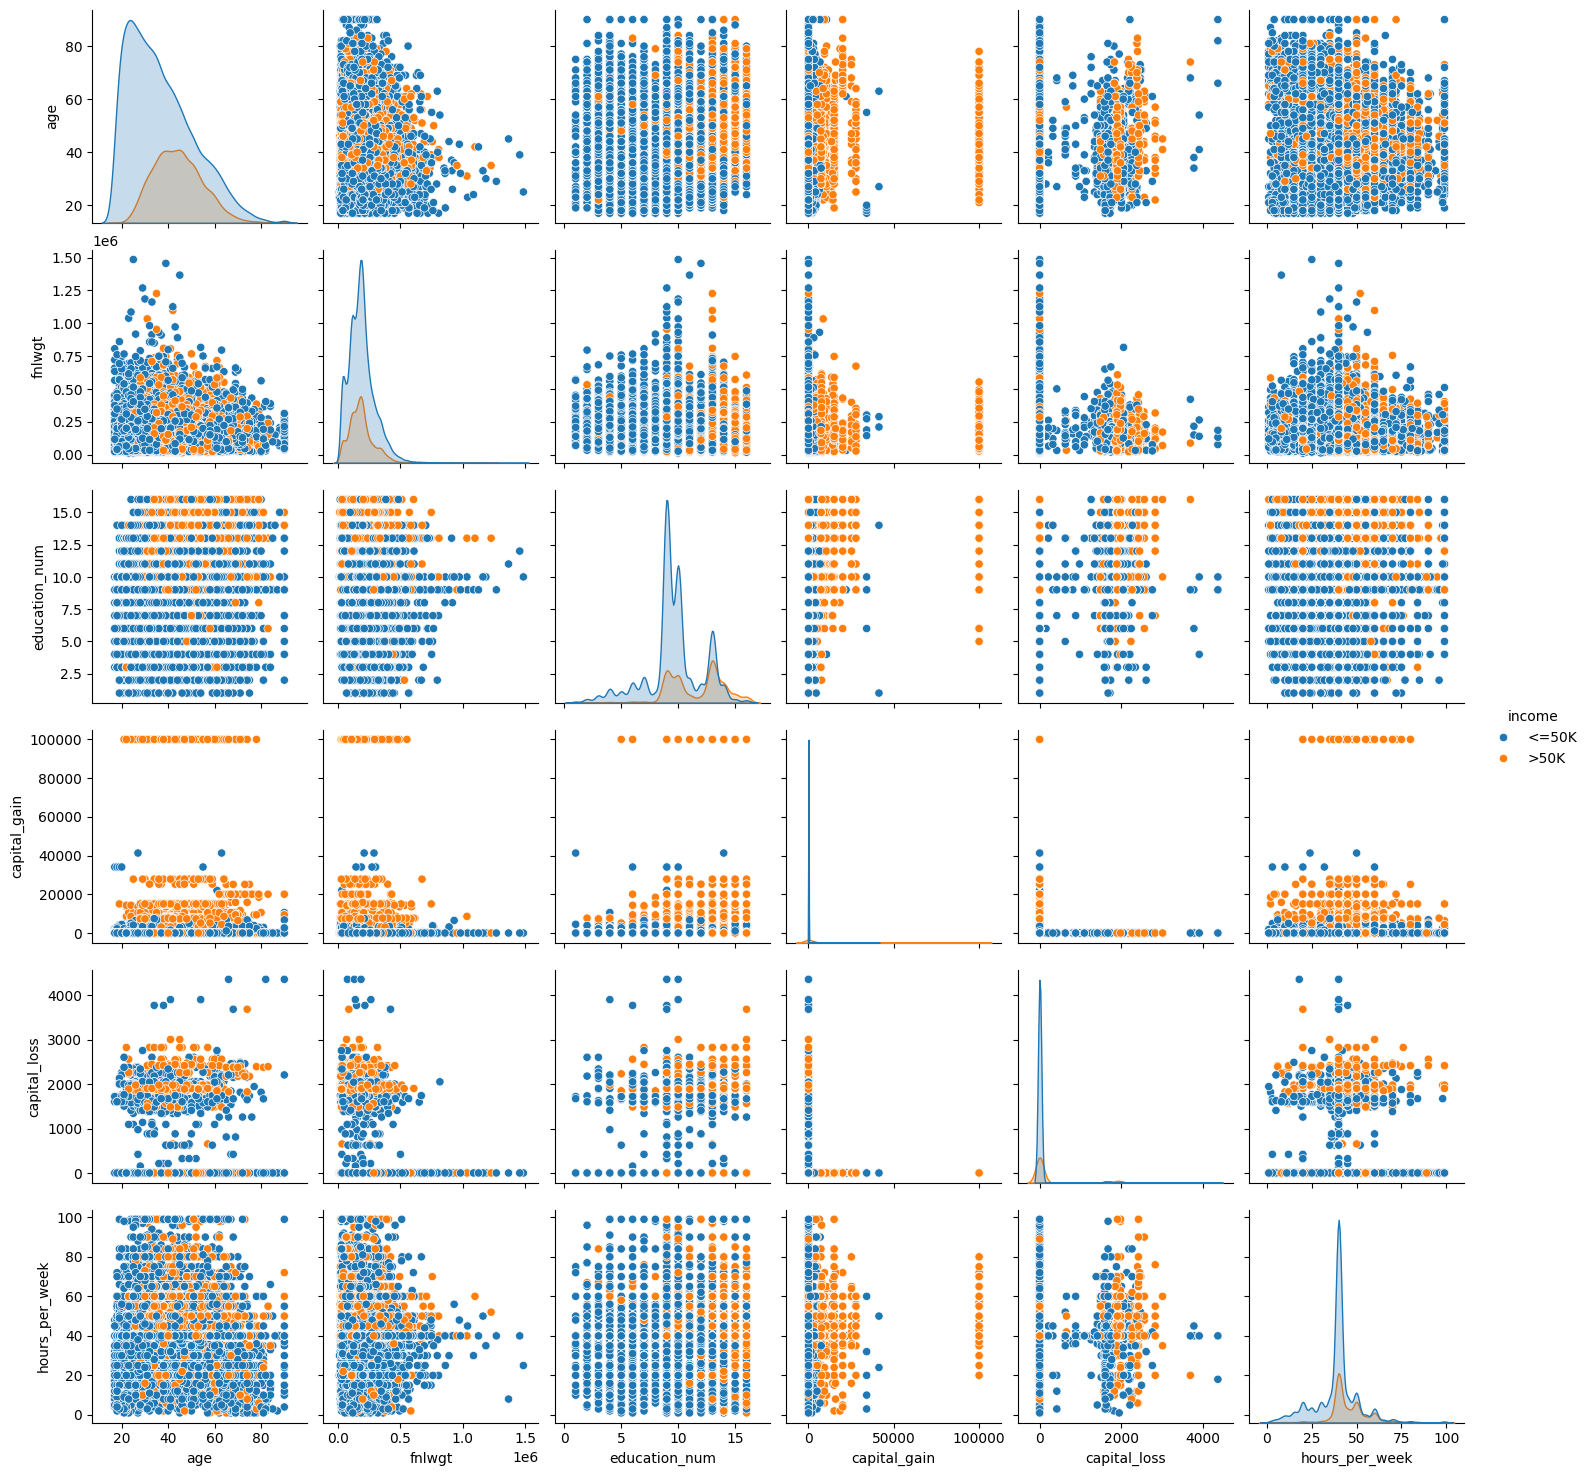

In [8]:
sns.pairplot(data=imputed_income_data_int, hue='income')

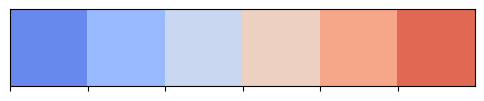

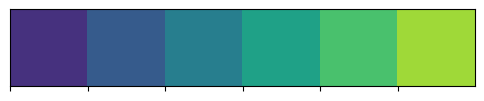

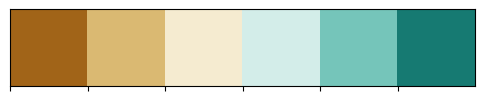

In [150]:
sns.palplot(sns.color_palette("coolwarm"))
sns.palplot(sns.color_palette("viridis"))
sns.palplot(sns.color_palette("BrBG"))
plt.show()